In [ ]:
from pathlib import Path
import torch
from torch import nn
from mltools import ld, draw, MachineLearning

In [ ]:
train_iter, val_iter, test_iter = ld.mnist('../data', batch_size=1000)  # 获取训练集、验证集和测试集
# 设置模型结构
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256), nn.ReLU(),
    nn.Linear(256, 10))
device = torch.device('cuda')  # 设置设备


class MLPMachineLearning(MachineLearning):
    pass


ml = MLPMachineLearning(model, train_iter, val_iter, test_iter, device=device)
model_path = '../model/MLP.pth'

train loss 0.240, val loss 0.243, val acc 0.930
0.3 sec/epoch on cuda


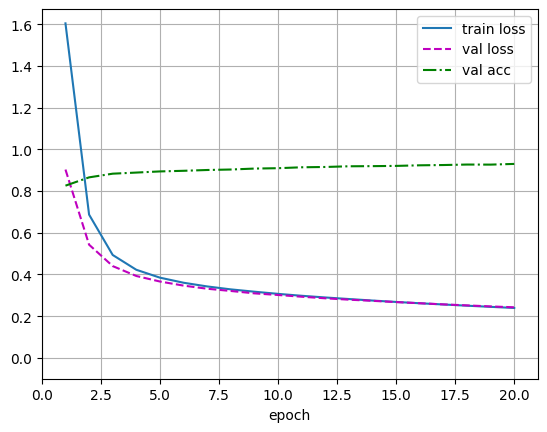

In [ ]:
if True:
    ml.train(num_epochs=20, learning_rate=1e-1)  # 训练
    if True:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
ml.test()  # 测试

Accuracy rate 0.9349


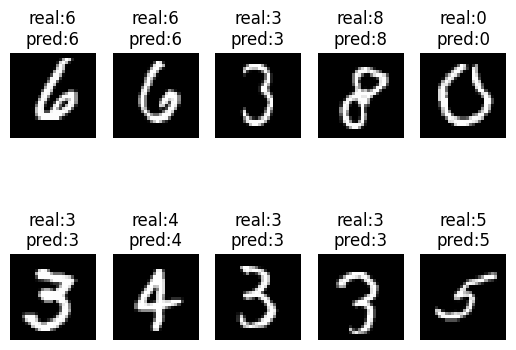

In [ ]:
# 预测模型
def predict(model, test_iter, device):
    model.to(device)  # 将网络复制到device上
    # 从测试中取一个批量
    x, y = next(iter(test_iter))
    x, y = x[:10].to(device), y[:10].to(device)
    # 预测
    y_pred = model(x).argmax(dim=1)
    labels = [f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x, labels, shape=(2, 5))


predict(model, test_iter, device)